# Capstone One Data Wrangling

In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# pandas options
pd.set_option('display.max_columns', 125) # csv contains 124 columns
pd.set_option('display.max_rows', 4000) # display more rows

In [3]:
data = pd.read_csv('montereyClimateData.csv') # had one float at end of this col
data.head()

/Users/trev7591a/.local/share/virtualenvs/Springboard-_vI4Xo1j/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (3,19,25,26,27,28,29,30,35,36,41,42,43,48,49,51,53,55,58,59,63,77,82,95,114,117,119) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,STATION,DATE,REPORT_TYPE,SOURCE,AWND,BackupDirection,BackupDistance,BackupDistanceUnit,BackupElements,BackupElevation,BackupElevationUnit,BackupEquipment,BackupLatitude,BackupLongitude,BackupName,CDSD,CLDD,DSNW,DailyAverageDewPointTemperature,DailyAverageDryBulbTemperature,DailyAverageRelativeHumidity,DailyAverageSeaLevelPressure,DailyAverageStationPressure,DailyAverageWetBulbTemperature,DailyAverageWindSpeed,DailyCoolingDegreeDays,DailyDepartureFromNormalAverageTemperature,DailyHeatingDegreeDays,DailyMaximumDryBulbTemperature,DailyMinimumDryBulbTemperature,DailyPeakWindDirection,DailyPeakWindSpeed,DailyPrecipitation,DailySnowDepth,DailySnowfall,DailySustainedWindDirection,DailySustainedWindSpeed,DailyWeather,HDSD,HTDD,HeavyFog,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyPresentWeatherType,HourlyPressureChange,HourlyPressureTendency,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlySkyConditions,HourlyStationPressure,HourlyVisibility,HourlyWetBulbTemperature,HourlyWindDirection,HourlyWindGustSpeed,HourlyWindSpeed,MonthlyAverageRH,MonthlyDaysWithGT001Precip,MonthlyDaysWithGT010Precip,MonthlyDaysWithGT32Temp,MonthlyDaysWithGT90Temp,MonthlyDaysWithLT0Temp,MonthlyDaysWithLT32Temp,MonthlyDepartureFromNormalAverageTemperature,MonthlyDepartureFromNormalCoolingDegreeDays,MonthlyDepartureFromNormalHeatingDegreeDays,MonthlyDepartureFromNormalMaximumTemperature,MonthlyDepartureFromNormalMinimumTemperature,MonthlyDepartureFromNormalPrecipitation,MonthlyDewpointTemperature,MonthlyGreatestPrecip,MonthlyGreatestPrecipDate,MonthlyGreatestSnowDepth,MonthlyGreatestSnowDepthDate,MonthlyGreatestSnowfall,MonthlyGreatestSnowfallDate,MonthlyMaxSeaLevelPressureValue,MonthlyMaxSeaLevelPressureValueDate,MonthlyMaxSeaLevelPressureValueTime,MonthlyMaximumTemperature,MonthlyMeanTemperature,MonthlyMinSeaLevelPressureValue,MonthlyMinSeaLevelPressureValueDate,MonthlyMinSeaLevelPressureValueTime,MonthlyMinimumTemperature,MonthlySeaLevelPressure,MonthlyStationPressure,MonthlyTotalLiquidPrecipitation,MonthlyTotalSnowfall,MonthlyWetBulb,NormalsCoolingDegreeDay,NormalsHeatingDegreeDay,REM,REPORT_TYPE.1,SOURCE.1,ShortDurationEndDate005,ShortDurationEndDate010,ShortDurationEndDate015,ShortDurationEndDate020,ShortDurationEndDate030,ShortDurationEndDate045,ShortDurationEndDate060,ShortDurationEndDate080,ShortDurationEndDate100,ShortDurationEndDate120,ShortDurationEndDate150,ShortDurationEndDate180,ShortDurationPrecipitationValue005,ShortDurationPrecipitationValue010,ShortDurationPrecipitationValue015,ShortDurationPrecipitationValue020,ShortDurationPrecipitationValue030,ShortDurationPrecipitationValue045,ShortDurationPrecipitationValue060,ShortDurationPrecipitationValue080,ShortDurationPrecipitationValue100,ShortDurationPrecipitationValue120,ShortDurationPrecipitationValue150,ShortDurationPrecipitationValue180,Sunrise,Sunset,TStorms,WindEquipmentChangeDate
0,72491523259,2009-04-01T00:08:00,FM-16,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.03,45,52,NaN,NaN,NaN,NaN,77,NaN,BKN:07 14,29.79,10.00,49,240,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MET07604/01/09 00:08:02 SPECI KMRY 010808Z 240...,FM-16,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,72491523259,2009-04-01T00:50:00,FM-16,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30.03,45,52,NaN,NaN,NaN,NaN,77,NaN,SCT:04 14,29.79,9.00,49,240,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MET07504/01/09 00:50:02 SPECI KMRY 010850Z 240...,FM-16,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

Get relevant columns from the data set:

In [124]:
df = data
columns = ['DATE', 
           'HourlySkyConditions', 
           'HourlyVisibility', 
           'HourlyDryBulbTemperature', 
           'HourlyWindSpeed', 
           'DailyMaximumDryBulbTemperature', 
           'DailyMinimumDryBulbTemperature', 
           'DailyPeakWindSpeed', 
           'DailyPrecipitation',
           'HourlyRelativeHumidity'
          ]
df = df.loc[:, columns]

### 1. Convert the 'DATE' column into a new datetime column full of datetime objects, and set this new column as the dataframe's index.

In [125]:
def date_val_to_datetime(to_parse):
    to_format = to_parse.split('T')
    return datetime.strptime(to_format[0] + ' ' + to_format[1], '%Y-%m-%d %H:%M:%S')

df['datetime'] = df.loc[:,'DATE'].apply(date_val_to_datetime)

### 2. Set this new column to be a datetime index for the dataframe.

In [126]:
df = df.set_index(['datetime'])

### 3. Convert strings to float across dataset where possible, replacing asterisks and suspect values with NaNs.

In [127]:
# all but hourly windspeed must be cleaned and converted to float for numeric processing
# many columns are missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124599 entries, 2009-04-01 00:08:00 to 2019-03-31 23:59:00
Data columns (total 10 columns):
DATE                              124599 non-null object
HourlySkyConditions               102830 non-null object
HourlyVisibility                  120764 non-null object
HourlyDryBulbTemperature          120422 non-null object
HourlyWindSpeed                   120617 non-null float64
DailyMaximumDryBulbTemperature    3601 non-null object
DailyMinimumDryBulbTemperature    3602 non-null object
DailyPeakWindSpeed                3611 non-null object
DailyPrecipitation                3610 non-null object
HourlyRelativeHumidity            120251 non-null object
dtypes: float64(1), object(9)
memory usage: 10.5+ MB


In [128]:
cols = ['HourlyVisibility', # columns to convert
 'HourlyDryBulbTemperature',
 'HourlyWindSpeed',
 'DailyMaximumDryBulbTemperature',
 'DailyMinimumDryBulbTemperature',
 'DailyPeakWindSpeed',
 'DailyPrecipitation',
 'HourlyRelativeHumidity',
       ]

# convert columns by applying to_numeric with error coersion
df.loc[:, cols] = df.loc[:, cols].apply(pd.to_numeric, errors='coerce')

In [129]:
# check for desired result
for c in cols:
    assert df.loc[:, c].dtypes == np.float64
    assert len(df.loc[df[c].astype(str).str[-1].isin(('*', 's'))]) == 0 # no values have the "suspect" suffix anymore

In [130]:
df.dtypes # and now all numeric fields are now floats

DATE                               object
HourlySkyConditions                object
HourlyVisibility                  float64
HourlyDryBulbTemperature          float64
HourlyWindSpeed                   float64
DailyMaximumDryBulbTemperature    float64
DailyMinimumDryBulbTemperature    float64
DailyPeakWindSpeed                float64
DailyPrecipitation                float64
HourlyRelativeHumidity            float64
dtype: object

### 4. Backfill the daily values to eliminate missing values: maximum daily temperature, minimum daily temperature, maximum daily wind speed, and daily precipitation columns throughout each day should have identical values.


In [131]:
df.loc[:,['DailyMaximumDryBulbTemperature', 'DailyMinimumDryBulbTemperature', 'DailyPeakWindSpeed', 'DailyPrecipitation']] = df.loc[:,['DailyMaximumDryBulbTemperature', 'DailyMinimumDryBulbTemperature', 'DailyPeakWindSpeed', 'DailyPrecipitation', 'HourlyRelativeHumidity']].bfill()

In [132]:
# many numeric columns are still missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124599 entries, 2009-04-01 00:08:00 to 2019-03-31 23:59:00
Data columns (total 10 columns):
DATE                              124599 non-null object
HourlySkyConditions               102830 non-null object
HourlyVisibility                  119459 non-null float64
HourlyDryBulbTemperature          120378 non-null float64
HourlyWindSpeed                   120617 non-null float64
DailyMaximumDryBulbTemperature    124598 non-null float64
DailyMinimumDryBulbTemperature    124598 non-null float64
DailyPeakWindSpeed                124598 non-null float64
DailyPrecipitation                124598 non-null float64
HourlyRelativeHumidity            120244 non-null float64
dtypes: float64(8), object(2)
memory usage: 10.5+ MB


### 5. Replace sky condition string list with a list of dictionaries. The sky condition is the key and a SkyCondition namedtuple is the value.

In [133]:
# column value is a string of a list of codes, 'BKN:07 15 OVC:08 20'
# desired output is a list of tuples, [('BKN', 7, 15), ('OVC', 8, 20)]
# clear days lack a second integer, i.e., 'CLR:00', appending 0 in place of missing value
from collections import namedtuple

SkyCondition = namedtuple('SkyCondition', 'obscuration, vertical_distance') # these will be the dict's values

def list_of_lists_by_n(the_list, n):
    """Yields the next n elements of a list as a sublist"""
    for i in range(0, len(the_list), n):  
        yield the_list[i:i + n] 
        
def from_many_to_two(the_string):
    split_at_spaces = the_string.split(' ')
    return list(list_of_lists_by_n(split_at_spaces, 2))

def from_two_to_three(list_of_lists):
    """
    input: ['CAPS:02', '35']
    output: {'CAPS':, SkyCondition(obscuration=02, vertical_distance=35)}
    """
    output = []
    for two_element_list in list_of_lists:
        first_element = two_element_list[0]
        if 2 >= len(first_element):
            return {} # for single trailing ints
        first_element_split = first_element.split(":")
        if 2 > len(two_element_list): 
            two_element_list.append(0) # catch CLR days missing following 00
        condition = SkyCondition(int(first_element_split[1]), int(two_element_list[1]))
        output.append({first_element_split[0]: condition})
    return output

def condition_string_to_namedtuple_dict(value):
    """
    Converts string containing several of the following to a list of dictionaries as follows:
    input: "CAPS:03 34"
    output: {'CAPS':, SkyCondition(obscuration=3, vertical_distance=34)}
    """
    if isinstance(value, float): # the only floats are np.nan, which is a float...with a str repr
        return [] # replace NaNs as an empty list
    the_string = value
    list_of_twos = from_many_to_two(the_string)
    return from_two_to_three(list_of_twos)

df['HourlySkyConditions'] = df['HourlySkyConditions'].apply(condition_string_to_namedtuple_dict)

### 6. Add an average obscuration score for each hour in the datset.

In [134]:
def calculate_average_obscuration(sky_conditions_for_hour):
    """Calculates the mean obscuration for each hour in the dataset"""
    if not sky_conditions_for_hour:
        return np.nan
    else:
        obscurations = [[y.obscuration for x, y in d.items()] for d in sky_conditions_for_hour]
        obscuration_mean = sum([x[0] for x in obscurations]) / len(obscurations) # calculate mean obscuration
        return obscuration_mean
    

df['averageObscuration'] = df['HourlySkyConditions'].apply(calculate_average_obscuration)

### 7. Deal with Missing Values

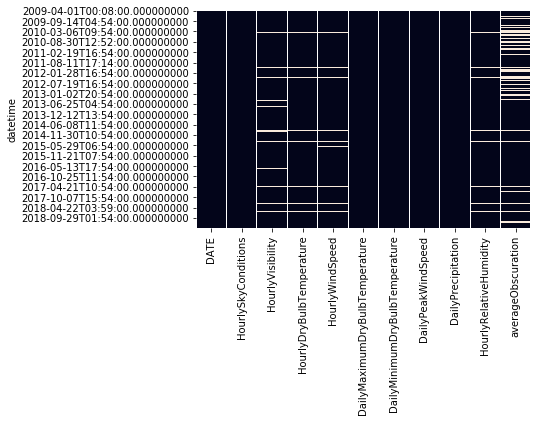

In [135]:
# visualize nans
sns.heatmap(df.isnull(), cbar=False)
plt.show()

Four hourly columns are missing values, in addition to the new average obscuration column. We impute the column mean for each column's missing values.

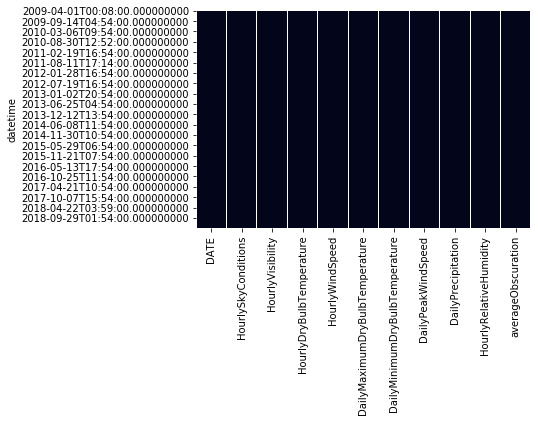

In [136]:
# impute the column mean for all remaining nan values in all numeric columns
x = df
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_cols = x.select_dtypes(include=numerics)

df.fillna({x:np.mean(df[x]) for x in numeric_cols.columns}, inplace=True)

sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [137]:
df.info() # looking pretty clean now

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 124599 entries, 2009-04-01 00:08:00 to 2019-03-31 23:59:00
Data columns (total 11 columns):
DATE                              124599 non-null object
HourlySkyConditions               124599 non-null object
HourlyVisibility                  124599 non-null float64
HourlyDryBulbTemperature          124599 non-null float64
HourlyWindSpeed                   124599 non-null float64
DailyMaximumDryBulbTemperature    124599 non-null float64
DailyMinimumDryBulbTemperature    124599 non-null float64
DailyPeakWindSpeed                124599 non-null float64
DailyPrecipitation                124599 non-null float64
HourlyRelativeHumidity            124599 non-null float64
averageObscuration                124599 non-null float64
dtypes: float64(9), object(2)
memory usage: 16.4+ MB


...and output a csv file for exploration.

### 8. Write Out the CSV

In [138]:
df.to_csv('cleaned_df.csv')